# TM10007 Assignment template -- ECG data

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

Importing modules

In [3]:
import os
import zipfile
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import shapiro 
from scipy.stats import lognorm
from scipy.spatial.distance import cdist
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import learning_curve
from imblearn.under_sampling import RandomUnderSampler
from sklearn import datasets as ds
from sklearn import model_selection
from sklearn import metrics
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

# Classifiers
from sklearn import neighbors
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB

# Required and still not used:
#import torch
#import seaborn

Importing our data

In [4]:
cwd = os.getcwd() # This fn will return the Current Working Directory

zip_path = os.path.join(cwd, 'ecg', 'ecg_data.zip')
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(os.path.join(cwd, 'ecg'))

data_path = os.path.join(cwd, 'ecg', 'ecg_data.csv')
data = pd.read_csv(data_path, index_col=0)

Exploring data part 1
- How many people have a normal ECG?
- How many people have an abnormal ECG?

In [5]:
# split labels from data
x = data.loc[:, data.columns != 'label']  #alles behalve label
y = data['label']  # labels

# normal / abnormal ECGs
total_abnormal_ECG = np.count_nonzero(y)  # current dataset has 146 nonzeros
total_normal_ECG = y.size -np.count_nonzero(y)  # current dataset has 681 zeros
percentage_abnormal = total_abnormal_ECG / (total_abnormal_ECG + total_normal_ECG)*100  # 17.65 %

Splitting data into training and test data
- Subset training and test based on ratios
- Stratification
- Balancing
- Scaling
- Outer cross-validation -> moet nog gedaan worden!

In [6]:
# Split data
X_train, X_test_DO_NOT_FIT, y_train, y_test_DO_NOT_FIT = model_selection.train_test_split(x, y, test_size=0.25, stratify=y)
y_train_ab = y_train==1  # waarom maken we hier bools van? ipv 1 en 0 hebben we nu true en false
# X_test_DO_NOT_FIT and y_test_DO_NOT_FIT SHOULD NOT BE USED FOR FITTING!!

# Balance data
rus = RandomUnderSampler(sampling_strategy={0: 109, 1:109})
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)


# Scale the data to be normal
scaler = preprocessing.RobustScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test_scaled_DO_NOT_FIT = scaler.transform(X_test_DO_NOT_FIT)

X_train=pd.DataFrame(X_train)
X_test_scaled_DO_NOT_FIT = pd.DataFrame(X_test_scaled_DO_NOT_FIT)

# Cross-validation
# cv_20fold = model_selection.StratifiedKFold(n_splits=10) --> uit college 1.2_generalization.ipyb

# Loop over the folds
#for validation_index, test_index in cv_20fold.split(X2, y2):
    # Split the data properly
#    X_validation = X2[validation_index]
#    y_validation = y2[validation_index]
    
#    X_test = X2[test_index]
#    y_test = y2[test_index]


Missing data
- Removing features if there is lot of data missing (replace all for a value)
- Removing samples (in this case patients) if there is a lot of data missing
- Imputation for generating data to fill us missing values -> median

In [7]:
# Missing data
X_train = X_train.replace(0, np.nan)  # make all zeros to NaN
nan_count = X_train.isna().sum().sum()  # count missing data -> 10500 in our dataset

# Delete missing data when > --% of feature of sample is missing
X_train = X_train.dropna(axis='columns', how='all') # deletes a feature if all values of a column (so feature) are empty
X_train = X_train.dropna(axis='rows', how='all') # deletes a patient if all values of a row (so sample) are empty

# Missing data to median per feature
for column in X_train.columns:
    X_train[column].fillna(X_train[column].median(), inplace=True)

Exploring data part 2
- Is the data normally distributed?

In [8]:
# Normally distributed
stat = []
p = []
for col in X_train.columns:
    if X_train[col].dtype == 'float64' or X_train[col].dtype == 'int64':
        s, pv = shapiro(X_train[col])
        stat.append(s)
        p.append(pv)
    else:
        stat.append(None)
        p.append(None)

Outliers
- Detect outliers using Z-score since data is not nornally distributed
- Replace outliers by the median of that feature
- Print -> check wether the outliers are changed

In [9]:
# create a new dataframe to store the results
results = pd.DataFrame({'Column': X_train.columns, 'W': stat, 'p-value': p}) 
mean_p_value = results['p-value'].mean()  # p-value is really small. If p-value is bigger than 0.05, then data is normally distributed. SO its not
median_p_value = results['p-value'].median()  # p-value is really small. If p-value is bigger than 0.05, then data is normally distributed. SO its not

# Outliers: Tukey's fence 
k=3
fences=pd.DataFrame()
outliers = pd.DataFrame(False, index=X_train.index, columns=X_train.columns) # create an empty DataFrame for outliers

for col in X_train.columns:
    q1, q3 = np.percentile(X_train[col], [25, 75])
    iqr = q3 - q1
    lower_fence = q1 - k*iqr
    upper_fence = q3 + k*iqr
    fences[col]=[lower_fence, upper_fence]
    for row in X_train.index:
        if X_train.loc[row, col] < lower_fence or X_train.loc[row, col] > upper_fence:
            outliers.loc[row, col] = True # mark the place as an outlier

row_count = (outliers == True).sum(axis=1)
col_count = (outliers == True).sum(axis=0)
total_count = row_count.sum() + col_count.sum()
print(f'The total outliers in dataset x is {total_count}')

C:\Users\Julia Binder\AppData\Local\Temp\ipykernel_12016\3304028950.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fences[col]=[lower_fence, upper_fence]
C:\Users\Julia Binder\AppData\Local\Temp\ipykernel_12016\3304028950.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fences[col]=[lower_fence, upper_fence]
C:\Users\Julia Binder\AppData\Local\Temp\ipykernel_12016\3304028950.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfor

The total outliers in dataset x is 343022


C:\Users\Julia Binder\AppData\Local\Temp\ipykernel_12016\3304028950.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fences[col]=[lower_fence, upper_fence]
C:\Users\Julia Binder\AppData\Local\Temp\ipykernel_12016\3304028950.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fences[col]=[lower_fence, upper_fence]
C:\Users\Julia Binder\AppData\Local\Temp\ipykernel_12016\3304028950.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfor

Het stuk hieronder mag naar de cell erboven als JIfkes feedback is verwerkt!

In [10]:
# create a copy of x to modify
new_x = X_train.copy()

# replace outliers with median of x by column
for col in outliers.columns:
    median = X_train.loc[outliers[col] == False, col].median() # median of column where outlier is False
    new_x.loc[outliers[col], col] = median # replace outliers with median

Om te controleren of de outliers nu echt weg zijn. Dit stukje hieronder mag weg zodra we JIfkes feedback hebben verwerkt met de outliers veranderen!

In [11]:
# # Check wether there are still outliers or not
# k=3
# fences=pd.DataFrame()
# outliers = pd.DataFrame(False, index=X_train.index, columns=X_train.columns) # create an empty DataFrame for outliers

# for col in new_x.columns:
#     q1, q3 = np.percentile(X_train[col], [25, 75])
#     iqr = q3 - q1
#     lower_fence = q1 - k*iqr
#     upper_fence = q3 + k*iqr
#     fences[col]=[lower_fence, upper_fence]
#     for row in new_x.index:
#         if new_x.loc[row, col] < lower_fence or new_x.loc[row, col] > upper_fence:
#             outliers.loc[row, col] = True # mark the place as an outlier

# row_count = (outliers == True).sum(axis=1)
# col_count = (outliers == True).sum(axis=0)
# total_count = row_count.sum() + col_count.sum()

# print(f'total outliers of the filtered x is {total_count}')

In [12]:
#change the x_train to the new_x
X_train = new_x.copy()
X_train_lasso = X_train.copy()

Feature selection:
- Remove features with zero variance

In [13]:
# sel_vt = VarianceThreshold(threshold=0.0)
# X_vt = sel_vt.fit_transform(X_train, y_train)
# print(X_vt.shape)

PCA
- How many principal components? (n=2/3) --> to make plots visual
- Scree plot to determine amount of features to use?


In [14]:
# # Reduce the number of features with PCA.
# n_samples = X_train.shape[0]
# n_features = X_train.shape[1]
# n_features = min(n_samples, n_features)

# pca = PCA(n_components=n_features)            
# X_train = pca.fit_transform(X_train)

# print(n_samples)
# print(n_features)
# print(pca.n_components_)

Univariate

In [15]:
# # selectKbest features 
# sel_kb = SelectKBest(f_classif, k='all')        # we trainen selector wel met 620 best en daarna pakken we pas de p_waarden --> kan dat wel?
# sel_kb.fit(X_train, y_train)                         # is het dan, omdat we alleen 'fit' doen en niet 'fit_transform' dat de k niet uitmaakt, omdat we X_train niet transformen, maar de 'empirical variances of X' nemen
# p_values = sel_kb.pvalues_
# print(p_values)

# # plot p-values of all features
# X_indices = np.arange(X_train.shape[-1])
# plt.figure(1)
# plt.clf()
# plt.bar(X_indices - 0.05, p_values, width=1)
# plt.axhline(y=0.05/X_train.shape[1], color='r', linestyle='-')
# plt.title("Feature univariate score")
# plt.xlabel("Feature number")
# plt.ylabel('p_values of all features')
# plt.show()


In [16]:
# # select features with p_value =< 0.05
# features_selected = np.array(np.where(p_values <= 0.05/X_train.shape[1]))
# print(len(sel_kb.pvalues_[sel_kb.pvalues_<0.05/X_train.shape[1]]))
# print(features_selected.shape)

# # select significant features in training set
# X_train = X_train[:,features_selected[0,:]]
# print(X_train.shape)

Function for PCA + univariatie

Vragen die er stonden over univariate:
- we trainen selector wel met 620 best en daarna pakken we pas de p_waarden --> kan dat wel?
- is het dan, omdat we alleen 'fit' doen en niet 'fit_transform' dat de k niet uitmaakt, omdat we X_train niet transformen, maar de 'empirical variances of X' nemen

In [17]:
def PCA_univariate(X_train, y_train):
    #Remove features with zero variance
    sel_vt = VarianceThreshold(threshold=0.0)
    X_vt = sel_vt.fit_transform(X_train, y_train)
    
    #PCA
    n_samples = X_train.shape[0]
    n_features = X_train.shape[1]
    n_features = min(n_samples, n_features)

    pca = PCA(n_components=n_features)            
    X_train = pca.fit_transform(X_train)

    #Univariate
    sel_kb = SelectKBest(f_classif, k='all')
    sel_kb.fit(X_train, y_train)
    p_values = sel_kb.pvalues_
    # select features with p_value =< 0.05
    features_selected = np.array(np.where(p_values <= 0.05/X_train.shape[1]))
    print(len(sel_kb.pvalues_[sel_kb.pvalues_<0.05/X_train.shape[1]]))
    print(features_selected.shape)
    # select significant features in training set
    X_train = X_train[:,features_selected[0,:]]
    
    return X_train


Stukje code om te gebruiken in je pipelines:
- dit later verwijderen als wij de pipelines allemala gemaakt hebben!

In [18]:
X_train = PCA_univariate(X_train,y_train)


         0         1         2         3         4         5         6     \
0    0.810252 -0.022959  0.364451 -0.542985  0.036222  0.112593  0.793822   
1   -0.004813  3.230300 -0.049856  0.817936  1.483708  1.113120  0.028573   
2   -0.022644  0.043760 -0.316534  0.308297  1.766164  0.850562 -0.331653   
3   -0.004780  0.016699 -0.033445 -0.352390 -0.074582  0.190501  0.049472   
4   -0.027983 -0.334847 -0.395939 -0.570818 -0.624128  0.054414 -0.589312   
..        ...       ...       ...       ...       ...       ...       ...   
615 -0.025851 -0.239349 -0.517083 -0.462996 -0.426811 -0.389212  0.043218   
616 -0.022358 -0.287796 -0.230770 -0.403381 -0.189364  0.301562 -0.338146   
617 -0.016852 -0.166947  0.033724 -0.355305  0.320678 -0.397977 -0.082527   
618  0.002800  0.456334  0.521964  0.383802 -0.070031  0.557161 -0.446229   
619 -0.022979 -0.301704 -0.113165 -0.452997 -0.353239 -0.000984  0.674370   

         7         8         9     ...      8990      8991      8992  \
0  

LASSO
- Feature selection

Vraag: moeten we hier niet ook de x gebruikt waarbij de features met zero variance al verwijderd zijn?

In [19]:
# # Define the Lasso model
# lasso = Lasso()

# # Define the grid of alpha values to search over
# alphas = np.logspace(-5, 1, 100)

# # Define the grid search
# grid_search = GridSearchCV(lasso, param_grid={'alpha': alphas}, cv=5)

# # Fit the grid search to your training data
# grid_search.fit(X_train_lasso, y_train)

# # Get the best alpha value from the grid search
# best_alpha = grid_search.best_params_['alpha']

# # Create a new Lasso model using the best alpha value
# lasso = Lasso(alpha=best_alpha)

# # Fit the Lasso model to your training data
# lasso.fit(X_train_lasso, y_train)

# # Get the coefficients of the Lasso model
# coef = lasso.coef_

# # Get the indices of the selected features
# selected_features = np.where(coef != 0)[0]

# # extract selected features
# X_train_lasso_features = X_train_lasso[selected_features]


c:\Users\Julia Binder\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.092e-02, tolerance: 6.642e-03
  model = cd_fast.enet_coordinate_descent(
c:\Users\Julia Binder\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.448e-02, tolerance: 7.430e-03
  model = cd_fast.enet_coordinate_descent(
c:\Users\Julia Binder\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality 

Function for LASSO feature selection

In [23]:
def LASSO_feature(X_train_lasso, y_train):
    # Define the Lasso model
    lasso = Lasso()

    # Grid search
    alphas = np.logspace(-5, 1, 100)  # Define the grid of alpha values to search over
    grid_search = GridSearchCV(lasso, param_grid={'alpha': alphas}, cv=5)
    grid_search.fit(X_train_lasso, y_train)
    best_alpha = grid_search.best_params_['alpha']

    # Create a new Lasso model using the best alpha value
    lasso = Lasso(alpha=best_alpha)
    lasso.fit(X_train_lasso, y_train)

    # Get the coefficients of the Lasso model, find them and define the new X_train with less features
    coef = lasso.coef_
    selected_features = np.where(coef != 0)[0]
    X_train_lasso = X_train_lasso[selected_features]
    return X_train_lasso

Stukje code om LASSO aan te roepen in je pipeline:

In [26]:
X_train_lasso = LASSO_feature(X_train_lasso,y_train)
print(X_train_lasso.shape)

c:\Users\Julia Binder\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.092e-02, tolerance: 6.642e-03
  model = cd_fast.enet_coordinate_descent(
c:\Users\Julia Binder\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.448e-02, tolerance: 7.430e-03
  model = cd_fast.enet_coordinate_descent(
c:\Users\Julia Binder\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality 

KeyboardInterrupt: 

Copying training dataset to be able to use them in our pipelines

In [20]:
X_train_pl_1 = X_train.copy()
X_train_pl_2 = X_train.copy()
X_train_pl_3 = X_train.copy()
X_train_pl_4 = X_train.copy()
X_train_pl_5 = X_train_lasso.copy()
X_train_pl_6 = X_train_lasso.copy()
X_train_pl_7 = X_train_lasso.copy()
X_train_pl_8 = X_train_lasso.copy()

Learning curves using PCA and univariate

KeyboardInterrupt: 

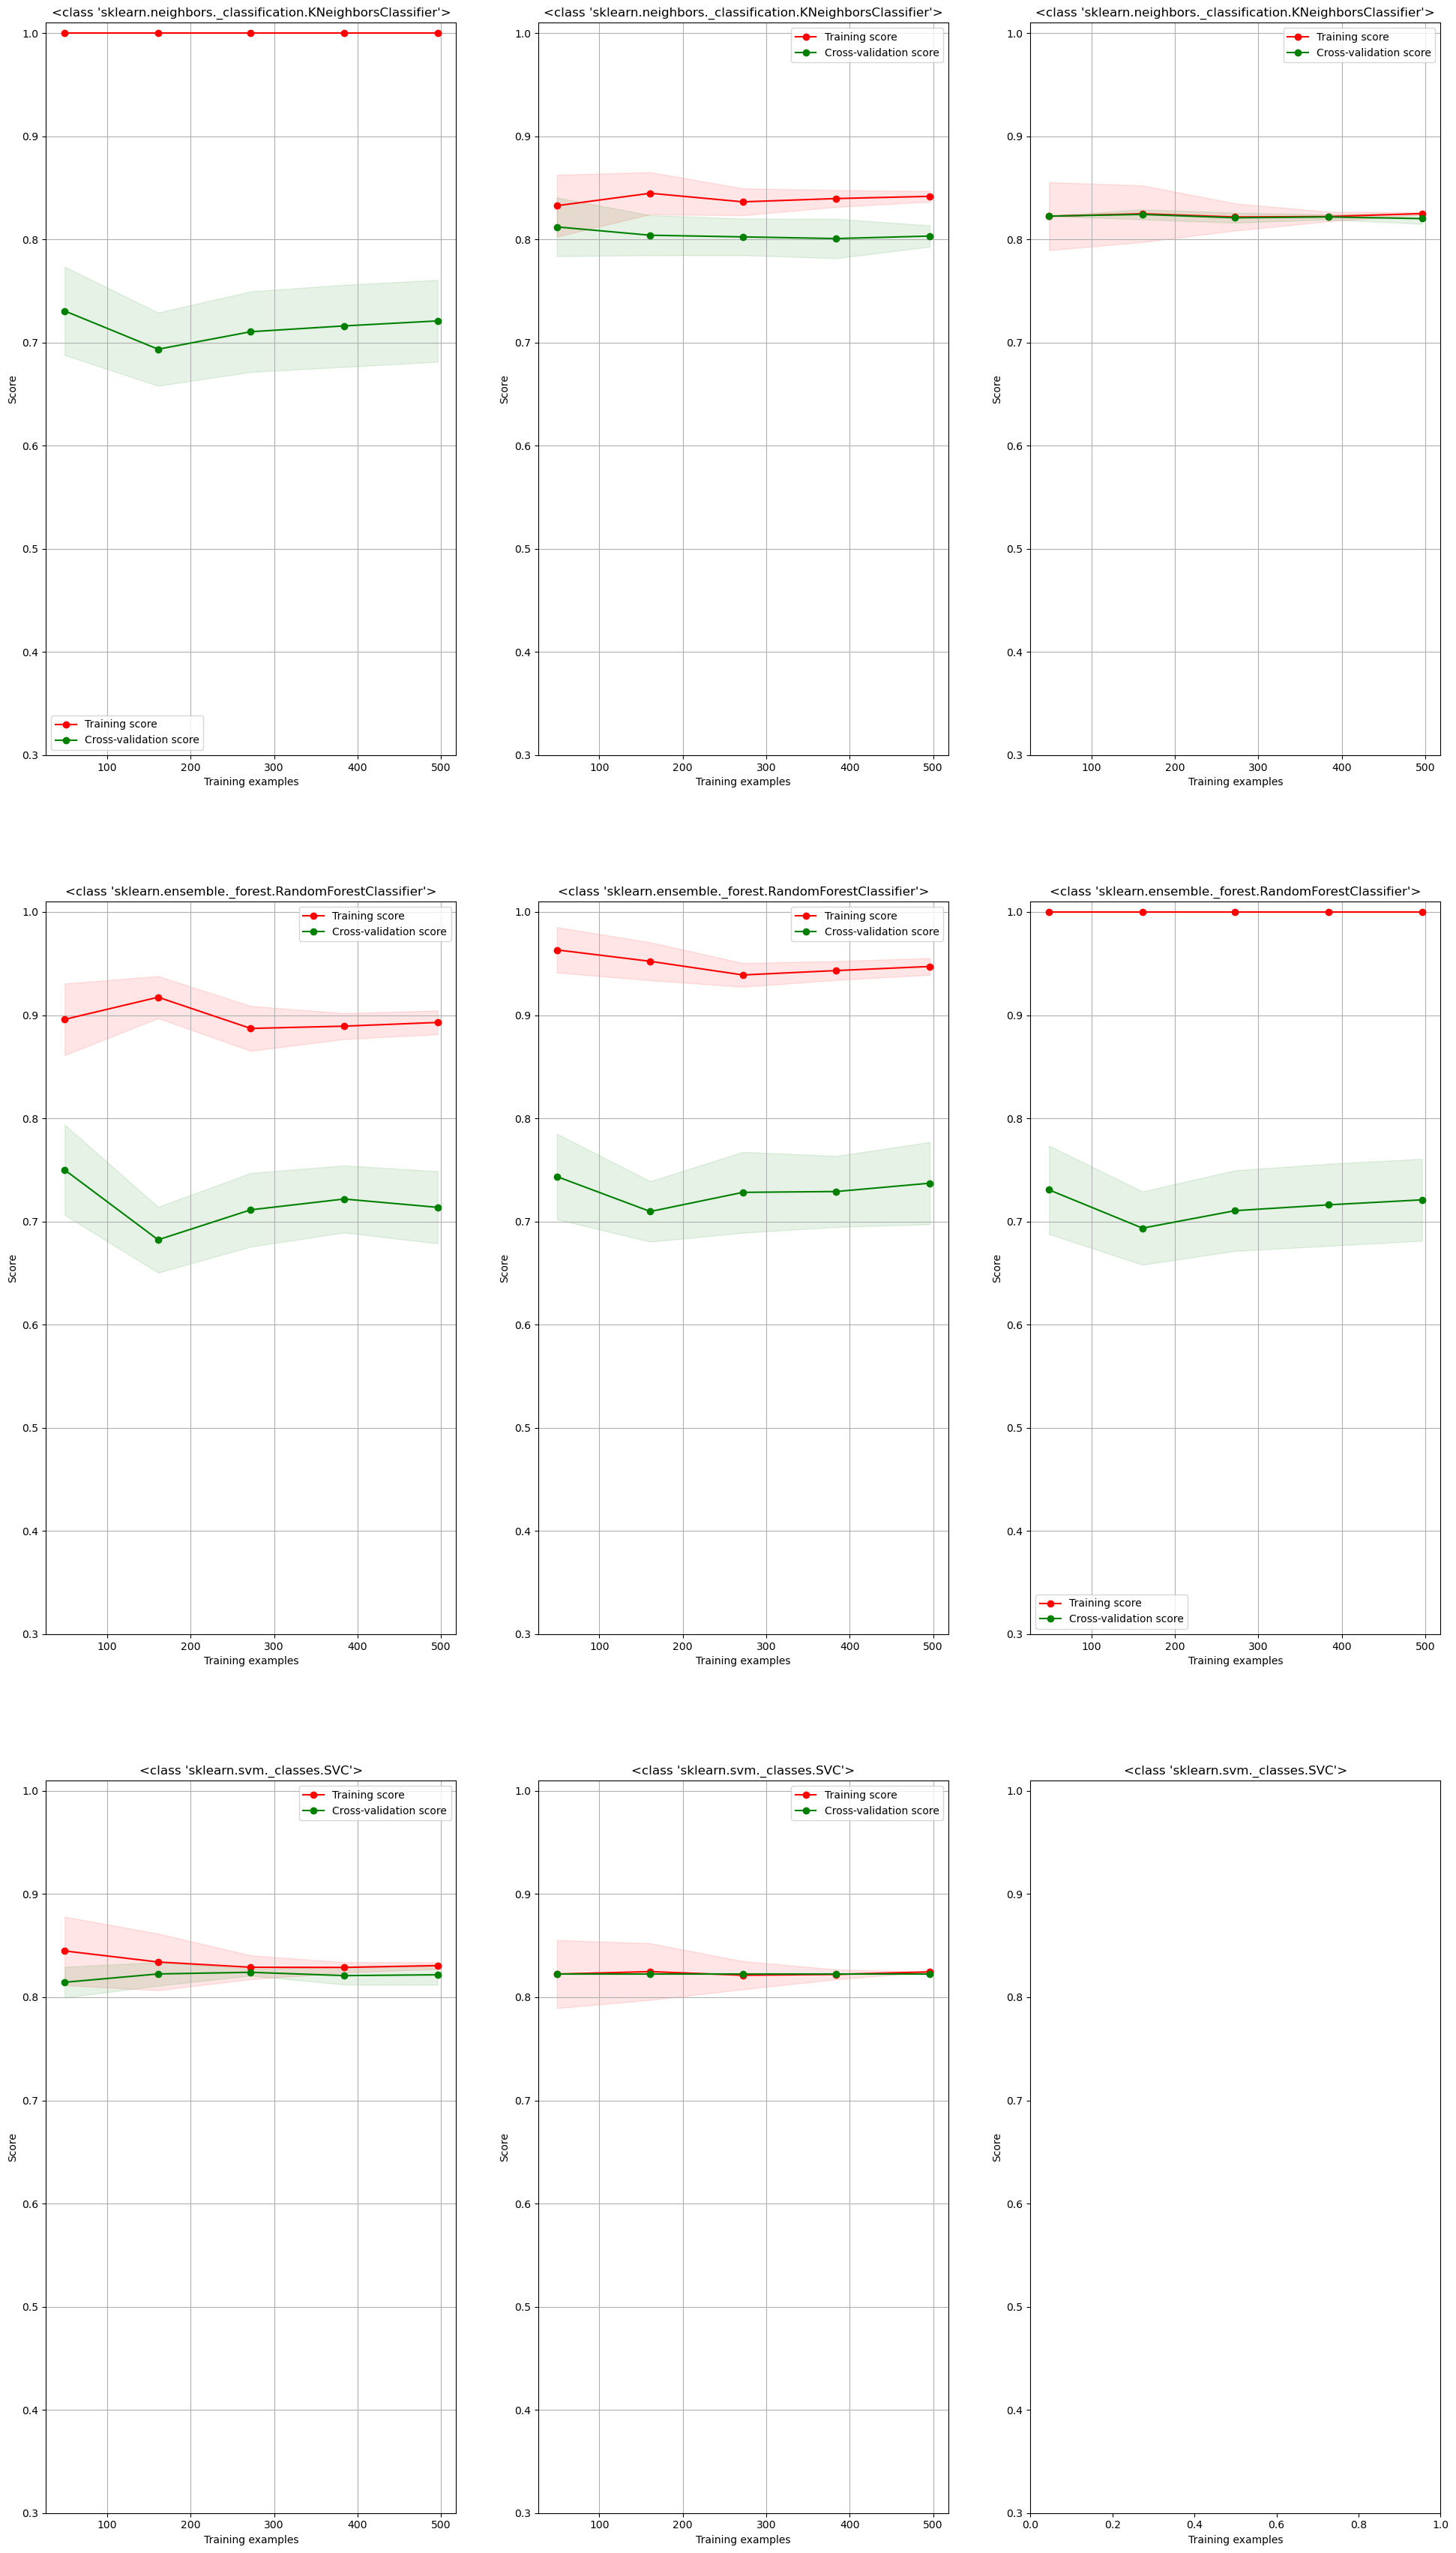

In [21]:
def plot_learning_curve(estimator, title, X, y, axes, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores  = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt

clsfs_all = [neighbors.KNeighborsClassifier(n_neighbors=1), 
         neighbors.KNeighborsClassifier(n_neighbors=5), 
         neighbors.KNeighborsClassifier(n_neighbors=20), 
         RandomForestClassifier(n_estimators=1, random_state=42),
         RandomForestClassifier(n_estimators=5, random_state=42),
         RandomForestClassifier(n_estimators=200, random_state=42),
         SVC(kernel='rbf', C=10, gamma=0.1),
         SVC(kernel='linear', C=10, gamma=0.1),
         SVC(kernel='poly', C=10, gamma=0.1),
         SVC(kernel='sigmoid', C=10, gamma=0.1),
         GaussianNB(),
         LinearSVC(),
         QuadraticDiscriminantAnalysis()
         ]

num=0
fig = plt.figure(figsize=(24,8*len(clsfs_all)))

# Create a cross-validation object
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

# Now use the classifiers on all datasets
for clf in clsfs_all:
    title = str(type(clf))
    ax = fig.add_subplot(7, 3, num + 1)
    plot_learning_curve(clf, title, X_train, y_train, ax, ylim=(0.3, 1.01), cv=cv)
    num += 1

Regularization
- SVM rbf
- SVM poly
- RF: 1,5,20
- quadratic

(620, 34)
(34,)
(620, 34)
(620,)


c:\Users\Julia Binder\miniconda3\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\Julia Binder\miniconda3\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\Julia Binder\miniconda3\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\Julia Binder\miniconda3\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\Julia Binder\miniconda3\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\Julia Binder\miniconda3\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables ar

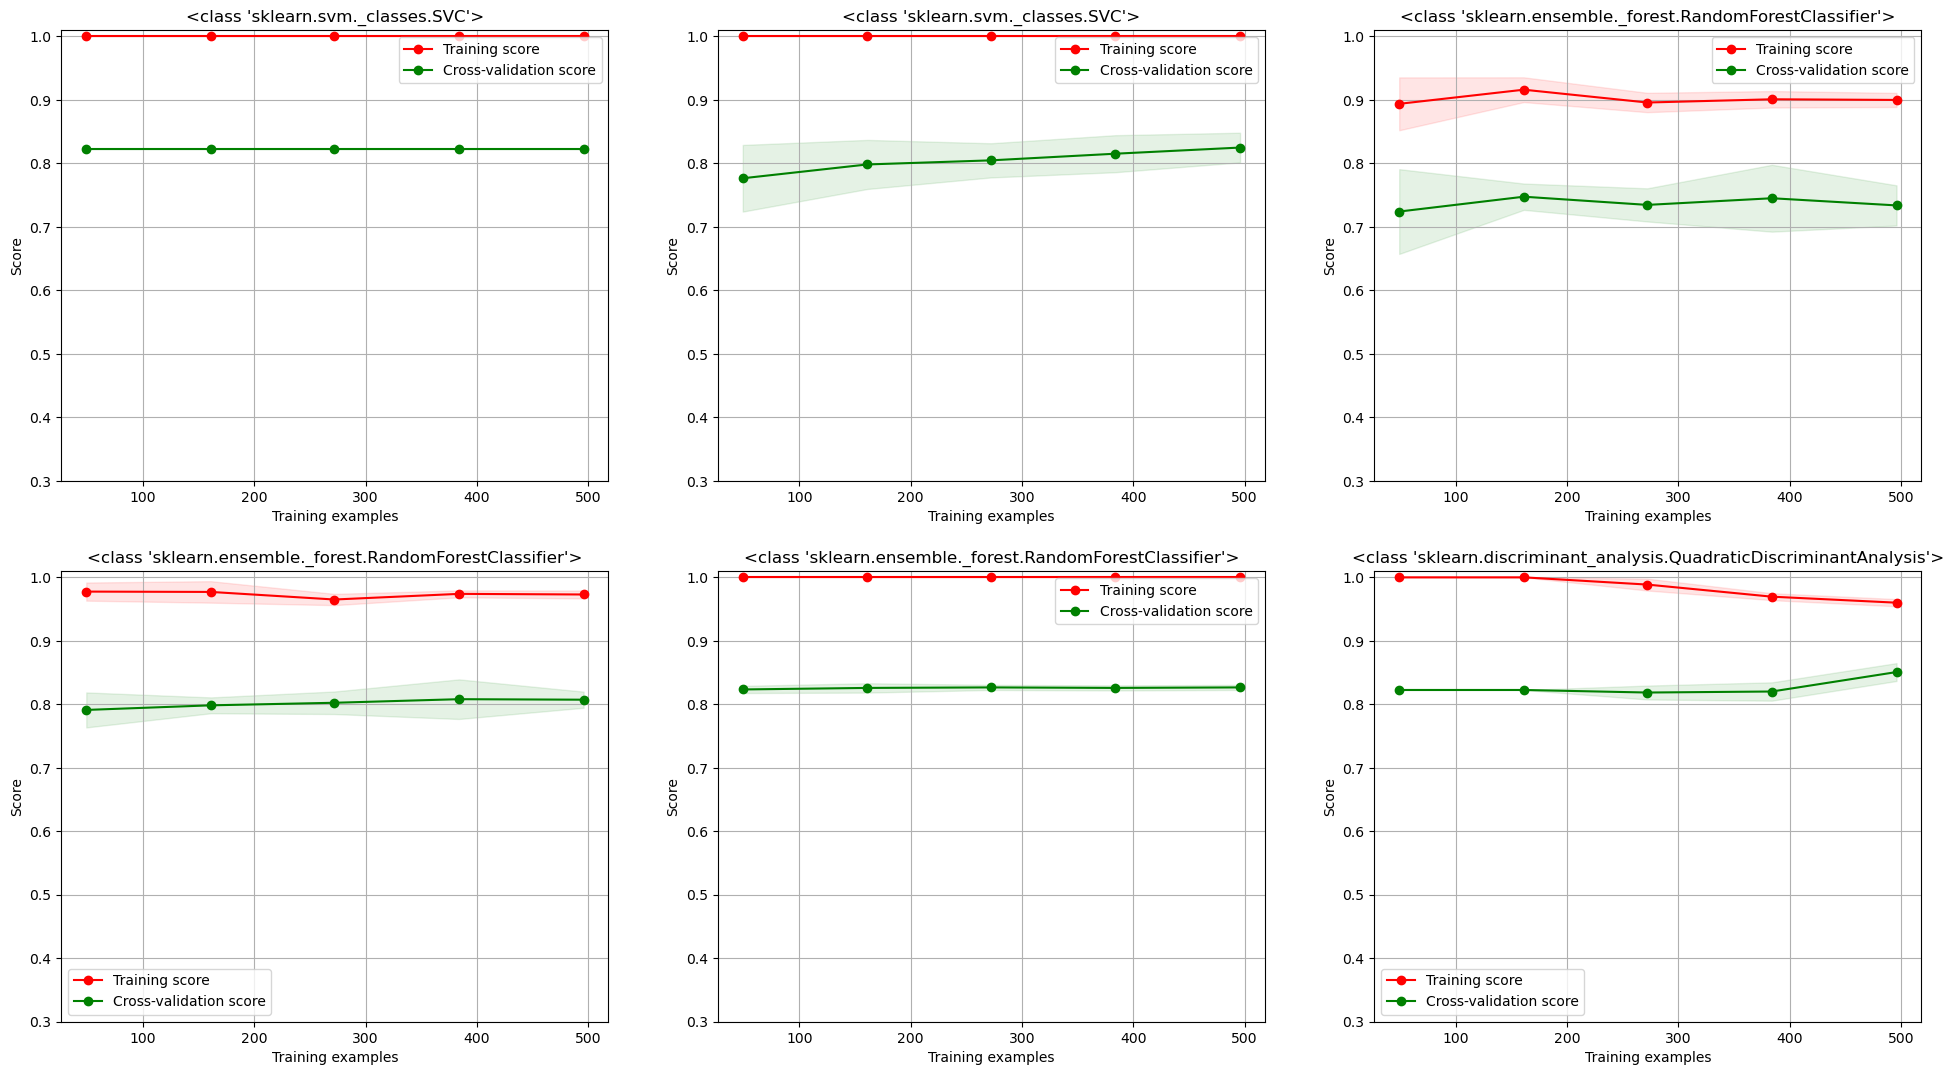

In [ ]:
# # Define the Lasso model
# lasso2 = Lasso()
# # Define the grid of alpha values to search over
# alphas2 = np.logspace(-5, 1, 100)
# # Define the grid search
# grid_search2 = GridSearchCV(lasso2, param_grid={'alpha': alphas2}, cv=5)
# # Fit the grid search to your training data
# grid_search2.fit(X_train, y_train)
# # Get the best alpha value from the grid search
# best_alpha2 = grid_search2.best_params_['alpha']
# # Create a new Lasso model using the best alpha value
# lasso2 = Lasso(alpha=best_alpha2)
# # Fit the Lasso model to your training data
# lasso2.fit(X_train, y_train)
# # Get the coefficients of the Lasso model
# coef2 = lasso2.coef_
# # Get the indices of the selected features
# selected_features2 = np.where(coef2 != 0)[0]
# #X_train_regularization = X_train[selected_features2]
# X_train_regularization = X_train[:, selected_features2]
# #X_train_regularization = X_train[:,selected_features2[0,:]]

print(X_train.shape)
X_train_regularization=LASSO_feature(X_train,y_train)
print(selected_features2.shape)
print(X_train_regularization.shape)
print(y_train.shape)



clsfs_regularization = [SVC(kernel='rbf', C=10, gamma=0.1),
         SVC(kernel='poly', C=10, gamma=0.1),
         RandomForestClassifier(n_estimators=1, random_state=42),
         RandomForestClassifier(n_estimators=5, random_state=42),
         RandomForestClassifier(n_estimators=200, random_state=42),
         QuadraticDiscriminantAnalysis()]

num=0
fig = plt.figure(figsize=(24,8*len(clsfs_regularization)))

# Create a cross-validation object
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

# Now use the classifiers on all datasets
for clf in clsfs_regularization:
    title = str(type(clf))
    ax = fig.add_subplot(7, 3, num + 1)
    plot_learning_curve(clf, title, X_train_regularization, y_train, ax, ylim=(0.3, 1.01), cv=cv)
    num += 1


Learning curves using LASSO as feature selection

c:\Users\Julia Binder\miniconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Julia Binder\miniconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Julia Binder\miniconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Julia Binder\miniconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Julia Binder\miniconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Julia Binder\miniconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Li

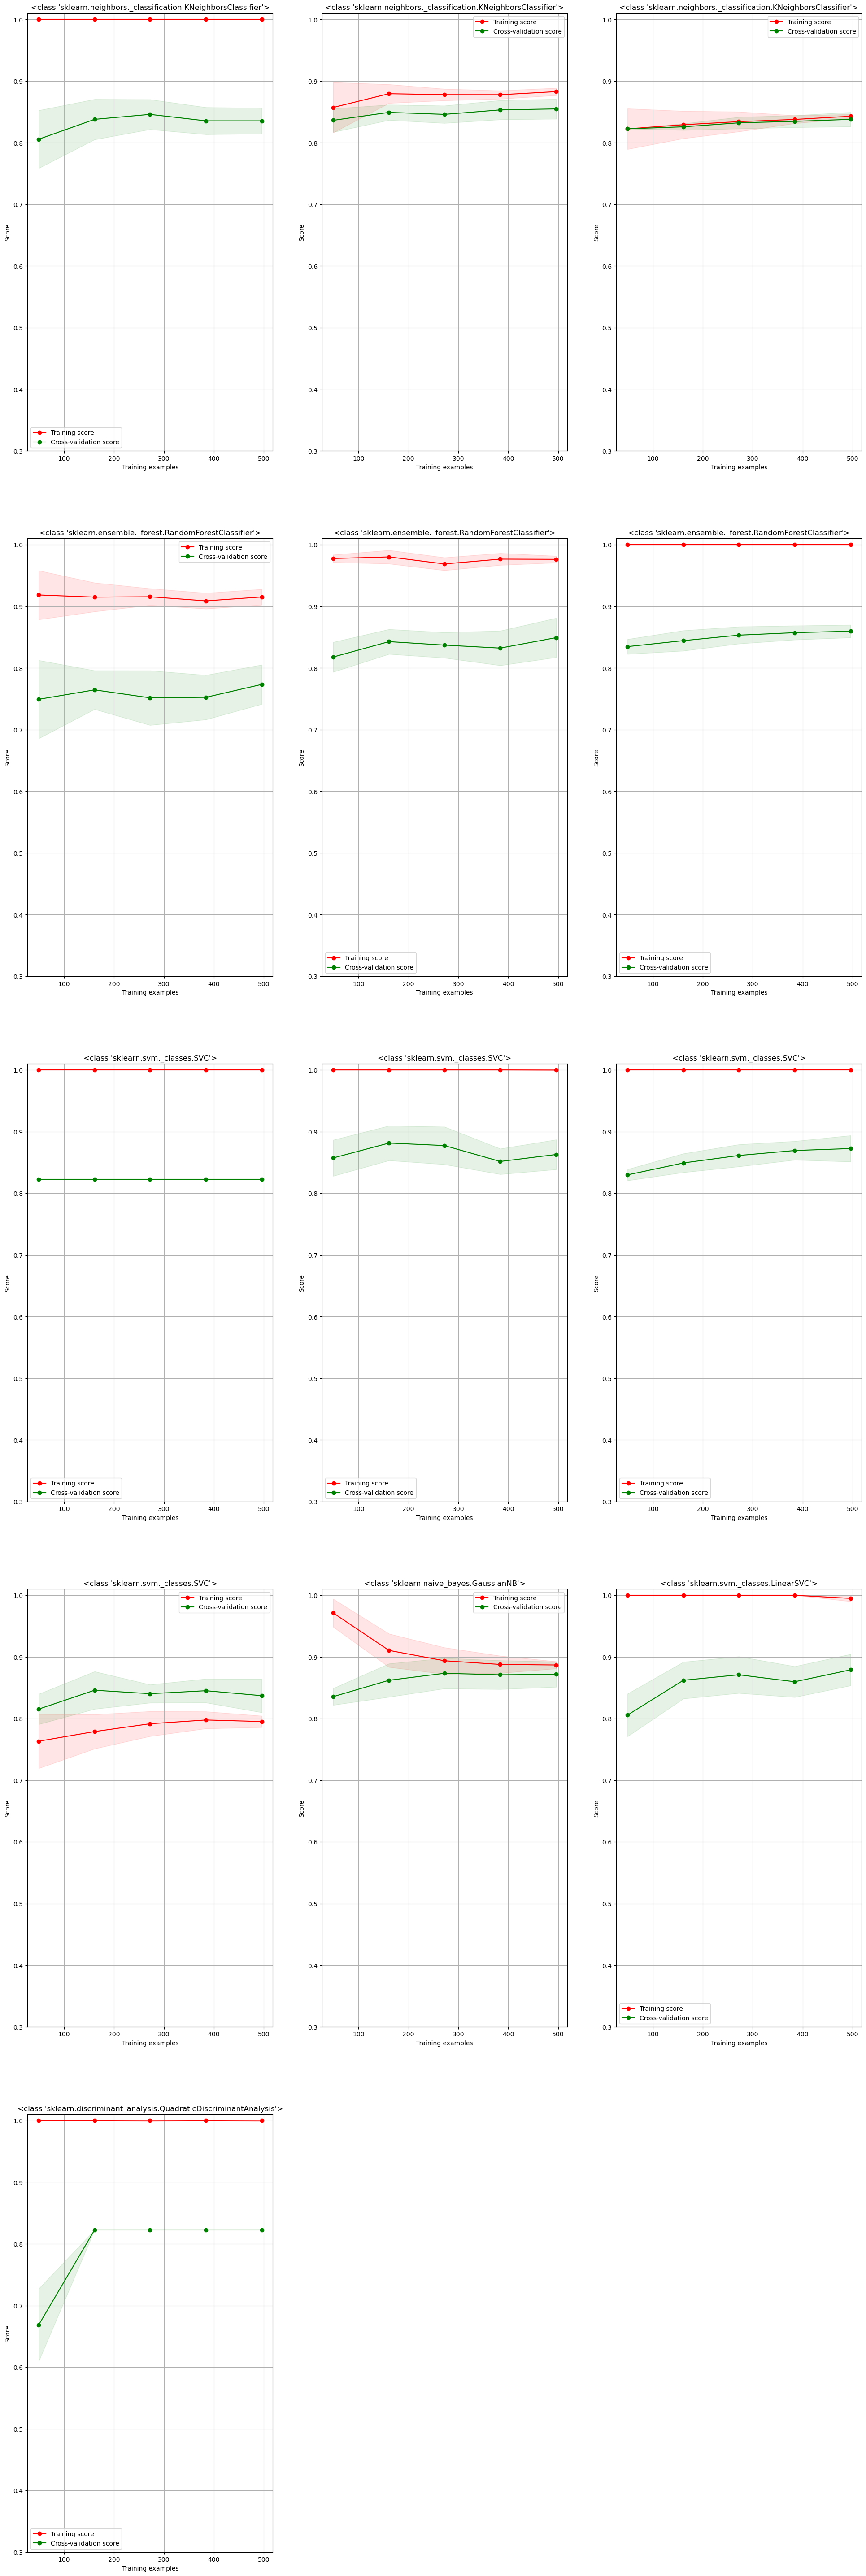

In [ ]:
num=0
fig = plt.figure(figsize=(24,8*len(clsfs_all)))

# Create a cross-validation object
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

# Now use the classifiers on all datasets
for clf in clsfs_al:
    title = str(type(clf))
    ax = fig.add_subplot(7, 3, num + 1)
    plot_learning_curve(clf, title, X_train_lasso_features, y_train, ax, ylim=(0.3, 1.01), cv=cv)
    num += 1

K-Neirest Neighbour classifier

In [ ]:
k_list = [1, 3, 7]
from sklearn import neighbors

for k in k_list:
    clf_knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    clf_knn.fit(X_train, y_train)

    # Test the classifier on the training data and plot
    score_train = clf_knn.score(X_train, y_train)

    # Test the classifier on the test data and plot
    # score_test = clf_knn.score(X_test_scaled_DO_NOT_FIT,y_test_DO_NOT_FIT)

# print(f'test score os {score_test}')
print(score_train)

0.864516129032258


*Support Vector Machines* 
Altough Support Vector Machines are quite intuitive and easy to use, they have quite a lot of hyperparameters. One general and highly important parameter is the slack C, which defaults to 1.0 in scikit learn. The SVM in scikit-learn contains defaults for the linear, polynomial and radial basis function kernels, and has options for their specific hyperparameters. However, SVMs also accept manually constructed and precomputed kernels.

*KNeighbours Classifiers*
*Random forest*
*Kernels*

In [ ]:
# Construct classifiers
svmlin = SVC(kernel='linear', gamma='scale')
svmrbf = SVC(kernel='rbf', gamma='scale')
svmpoly = SVC(kernel='poly', degree=3, gamma='scale')

clsfs = [KNeighborsClassifier(), RandomForestClassifier(), svmlin, svmpoly, svmrbf]



for clf in clsfs:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_train)
    print('Misclassified: %d / %d' % ((y_train != y_pred).sum(), X_train.shape[0]))

Misclassified: 80 / 620
Misclassified: 0 / 620
Misclassified: 55 / 620
Misclassified: 70 / 620
Misclassified: 56 / 620


# KNN Hyperparameter tuning

## Pipeline 1
PCA+univariate

In [ ]:
# Create a 20 fold stratified CV iterator
cv_20fold = model_selection.StratifiedKFold(n_splits=10)
results = []
best_n_neighbors = []
    
# Create a grid search to find the optimal k using a gridsearch and 10-fold cross validation
# Same as above
parameters = {"n_neighbors": list(range(1, 26, 2))}
knn = neighbors.KNeighborsClassifier()
cv_10fold = model_selection.StratifiedKFold(n_splits=10)
grid_search = model_selection.GridSearchCV(knn, parameters, cv=cv_10fold, scoring='roc_auc')
grid_search.fit(X_train_pl_1, y_train)
    
# Get resulting classifier
clf = grid_search.best_estimator_
print(f'Best classifier: k={clf.n_neighbors}')

best_estimator = int(clf.n_neighbors)
print(clf)

# fit the k with the optimal 
knn_best = KNeighborsClassifier(best_estimator)
knn_best.fit(X_train_pl_1,y_train)
y_pred = knn_best.predict(X_train_pl_1)

if hasattr(knn_best, 'predict_proba'):
    # The first column gives the probability for class = 0, so we take
    # the second which gives the probability class = 1:
        y_score = knn_best.predict_proba(X_train_pl_1)[:, 1]
else:
    y_score = y_pred

auc=metrics.roc_auc_score(y_train, y_score)

print(f'The auc is {auc}')

Best classifier: k=25
KNeighborsClassifier(n_neighbors=25)
The auc is 0.8282464676206036


## Pipeline 5
LASSO

In [ ]:

# Create a 20 fold stratified CV iterator
cv_20fold = model_selection.StratifiedKFold(n_splits=10)
results = []
best_n_neighbors = []
    
# Create a grid search to find the optimal k using a gridsearch and 10-fold cross validation
# Same as above
parameters = {"n_neighbors": list(range(1, 26, 2))}
knn = neighbors.KNeighborsClassifier()
cv_10fold = model_selection.StratifiedKFold(n_splits=10)
grid_search = model_selection.GridSearchCV(knn, parameters, cv=cv_10fold, scoring='roc_auc')
grid_search.fit(X_train_pl_5, y_train)
    
# Get resulting classifier
clf = grid_search.best_estimator_
print(f'Best classifier: k={clf.n_neighbors}')

best_estimator = int(clf.n_neighbors)
print(clf)

# fit the k with the optimal 
knn_best = KNeighborsClassifier(best_estimator)
knn_best.fit(X_train_pl_5,y_train)
y_pred = knn_best.predict(X_train_pl_5)

if hasattr(knn_best, 'predict_proba'):
    # The first column gives the probability for class = 0, so we take
    # the second which gives the probability class = 1:
        y_score = knn_best.predict_proba(X_train_pl_5)[:, 1]
else:
    y_score = y_pred

auc=metrics.roc_auc_score(y_train, y_score)

print(f'The auc is {auc}')

Best classifier: k=9
KNeighborsClassifier(n_neighbors=9)
The auc is 0.8724662920339684


# Gaussian hyperparameter tuning

## Pipeline 3
PCA/Univariate

In [ ]:
# optimizing var_smoothing parameter
best_estimator = []

param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}
gnb = GaussianNB()

# performing a grid search using 10-fold stratified cv
cv_10fold = model_selection.StratifiedKFold(n_splits=10)
grid_nb = GridSearchCV(gnb, param_grid_nb, cv=cv_10fold, scoring='roc_auc')
# fit the grid search onto the training data
grid_nb.fit(X_train_pl_3, y_train)

#find the best var_smoothing value
best_nb_model = grid_nb.best_estimator_
best_estimator = float(best_nb_model.var_smoothing)
print(grid_nb.best_estimator_)

# fit the GaussianNB with the optimal var_smoothing
gnb_best = GaussianNB(var_smoothing=best_estimator)
gnb_best.fit(X_train_pl_3,y_train)
y_pred = gnb_best.predict(X_train_pl_3)

if hasattr(gnb_best, 'predict_proba'):
    # The first column gives the probability for class = 0, so we take
    # the second which gives the probability class = 1:
        y_score = gnb_best.predict_proba(X_train_pl_3)[:, 1]
else:
    y_score = y_pred

auc=metrics.roc_auc_score(y_train, y_score)

print(f'The auc is {auc}')
# cv results
#pd.DataFrame(grid_nb.cv_results_)

GaussianNB(var_smoothing=0.02310129700083159)
The auc is 0.877053447997271


## Pipeline 7
LASSO

In [ ]:
# optimizing var_smoothing parameter
best_estimator = []

param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}
gnb = GaussianNB()

# performing a grid search using 10-fold stratified cv
cv_10fold = model_selection.StratifiedKFold(n_splits=10)
grid_nb = GridSearchCV(gnb, param_grid_nb, cv=cv_10fold, scoring='roc_auc')
# fit the grid search onto the training data
grid_nb.fit(X_train_pl_7, y_train)

#find the best var_smoothing value
best_nb_model = grid_nb.best_estimator_
best_estimator = float(best_nb_model.var_smoothing)
print(grid_nb.best_estimator_)

# fit the GaussianNB with the optimal var_smoothing
gnb_best = GaussianNB(var_smoothing=best_estimator)
gnb_best.fit(X_train_pl_7,y_train)
y_pred = gnb_best.predict(X_train_pl_7)

if hasattr(gnb_best, 'predict_proba'):
    # The first column gives the probability for class = 0, so we take
    # the second which gives the probability class = 1:
        y_score = gnb_best.predict_proba(X_train_pl_7)[:, 1]
else:
    y_score = y_pred

auc=metrics.roc_auc_score(y_train, y_score)

print(f'The auc is {auc}')

GaussianNB(var_smoothing=1.0)
The auc is 0.7731377583080487


# Support Vector Machine Hyperparameter tuning
- No gamma because that is only in 'rbf', 'poly' or 'sigmoid' and we only use 'linear'
- Tuning of C

## Pipeline 2 & 6

In [ ]:
# Check default values
svc = SVC()
params = svc.get_params()
params_df = pd.DataFrame(params, index=[0])
params_df.T

# Run model pipeline 2
svc.fit(X_train_pl_2, y_train)
# Accuracy score
# print(f'The accuracy score of the model is {svc.score(X_test_scaled_DO_NOT_FIT, y_test_DO_NOT_FIT):.4f}')

# List of C values
C_range_2 = np.logspace(-3, 1, 20)
print(f'The list of values for C are {C_range_2}')

# Define the search space
param_grid_2 = { 
    # Regularization parameter.
    "C": C_range_2,
    # Kernel type
    "kernel": ['linear'],
    }
# Set up score
# scoring_2 = ['accuracy'] For using accuracy
scoring_2 = ['roc_auc']
# Set up the k-fold cross-validation
kfold_2 = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Define grid search
grid_search_2 = GridSearchCV(estimator=svc, 
                           param_grid=param_grid_2, 
                           scoring=scoring_2, 
                           #refit='accuracy', 
                           refit = 'roc_auc',
                           n_jobs=-1, 
                           cv=kfold_2, 
                           verbose=0)
# Fit grid search
grid_result_2 = grid_search_2.fit(X_train_pl_2, y_train)
# Print grid search summary
print(grid_result_2)

# Print the best accuracy score for the training dataset
print(f'The best accuracy score for the training dataset is {grid_result_2.best_score_:.4f}')
# Print the hyperparameters for the best score
print(f'The best hyperparameters are {grid_result_2.best_params_}')
# Print the best accuracy score for the testing dataset
#print(f'The accuracy score for the testing dataset is {grid_search_2.score(X_test_scaled_DO_NOT_FIT, y_test_DO_NOT_FIT):.4f}')
# dit kan nog niet want teveel features omdat de selectie nog niet is toegepast op x_test, daarnaast mag het nog niet


# Run model pipeline 6
svc.fit(X_train_pl_6, y_train)
# Accuracy score
#print(f'The accuracy score of the model is {svc.score(X_test_scaled_DO_NOT_FIT, y_test_DO_NOT_FIT):.4f}')

# List of C values
C_range_6 = np.logspace(-3, 1, 20)
print(f'The list of values for C are {C_range_6}')

# Define the search space
param_grid_6 = { 
    # Regularization parameter.
    "C": C_range_6,
    # Kernel type
    "kernel": ['linear'],
}
# Set up score
scoring_6 = ['roc_auc']
# Set up the k-fold cross-validation
kfold_6 = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Define grid search
grid_search_6 = GridSearchCV(estimator=svc, 
                           param_grid=param_grid_6, 
                           scoring=scoring_6, 
                           # refit='accuracy', 
                           refit = 'roc_auc',
                           n_jobs=-1, 
                           cv=kfold_6, 
                           verbose=0)
# Fit grid search
grid_result_6 = grid_search_6.fit(X_train_pl_6, y_train)
# Print grid search summary
print(grid_result_6)

# Print the best accuracy score for the training dataset
print(f'The best accuracy score for the training dataset is {grid_result_6.best_score_:.4f}')
# Print the hyperparameters for the best score
print(f'The best hyperparameters are {grid_result_6.best_params_}')
# Print the best accuracy score for the testing dataset
#print(f'The accuracy score for the testing dataset is {grid_search_6.score(X_test_scaled_DO_NOT_FIT, y_test_DO_NOT_FIT):.4f}')
# dit kan nog niet want teveel features omdat de selectie nog niet is toegepast op x_test, daarnaast mag het nog niet


The list of values for C are [1.00000000e-03 1.62377674e-03 2.63665090e-03 4.28133240e-03
 6.95192796e-03 1.12883789e-02 1.83298071e-02 2.97635144e-02
 4.83293024e-02 7.84759970e-02 1.27427499e-01 2.06913808e-01
 3.35981829e-01 5.45559478e-01 8.85866790e-01 1.43844989e+00
 2.33572147e+00 3.79269019e+00 6.15848211e+00 1.00000000e+01]
GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=SVC(), n_jobs=-1,
             param_grid={'C': array([1.00000000e-03, 1.62377674e-03, 2.63665090e-03, 4.28133240e-03,
       6.95192796e-03, 1.12883789e-02, 1.83298071e-02, 2.97635144e-02,
       4.83293024e-02, 7.84759970e-02, 1.27427499e-01, 2.06913808e-01,
       3.35981829e-01, 5.45559478e-01, 8.85866790e-01, 1.43844989e+00,
       2.33572147e+00, 3.79269019e+00, 6.15848211e+00, 1.00000000e+01]),
                         'kernel': ['linear']},
             refit='roc_auc', scoring=['roc_auc'])
The best accuracy score for the training dataset is 0.8998
The 